In [1]:
## data
import pandas as pd
import numpy as np

## model
import sklearn.linear_model

## cv
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold

## visualization
import matplotlib.pyplot as plt

## utilities
import pickle
import warnings

## 한글 폰트 표시
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## warnings 처리
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
housing_price = pd.read_csv("kc_house_data.csv")

## 전처리
df_preprocessed = housing_price.drop(["id", "date", "price"], axis = 1)\
.assign(date = pd.to_datetime(housing_price.date)).assign(price = housing_price.price)

## scores recoding
scoring_dict = dict()

In [3]:
def month_days_split(df_train : pd.DataFrame, df_test : pd.DataFrame) :
    """
    train/test set에서 `date` 열을 월별과 일별로 따로 분석하기 위한 함수
    """
    test_month = df_test.date.dt.month.astype(str)
    test_days = df_test.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    train_month = df_train.date.dt.month.astype(str)
    train_days = df_train.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    
    return [train_month, train_days], [test_month, test_days]

df_train, df_test = train_test_split(df_preprocessed, test_size = 0.3, shuffle = True, random_state = 14107)
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

train_date, test_date = month_days_split(df_train, df_test)

In [57]:
with open("scoring_dict.pkl", "rb") as f :
    scoring_dict = pickle.load(f)

In [8]:
X = pd.get_dummies(df_train.drop(["date", "price"], axis = 1).assign(month = train_date[0]), drop_first = True, dtype = int)
y = df_train.price

XX = pd.get_dummies(df_test.drop(["date", "price"], axis = 1).assign(month = test_date[0]), drop_first = True, dtype = int)
yy = df_test.price

In [32]:
10**(-5)

1e-05

In [53]:
## fitting scaler with train set
numeric_features = list(set(df_train.columns) - set(["price", "date", "waterfront"])) ## date : 선형이므로 월별로 설정(더미변수 처리)
scalr = StandardScaler()
y_scalr = PowerTransformer()
standarized_features = scalr.fit_transform(df_train.loc[:, numeric_features])

## train data
X_trans = np.concatenate([standarized_features, np.asarray(pd.get_dummies(train_date[0], drop_first = True, dtype = int).assign(waterfront = df_train.waterfront))], axis = 1) # features
y_trans = np.asarray(y_scalr.fit_transform(pd.DataFrame(df_train.price))).reshape(-1) ## scaled target

## test data
XX_trans = np.concatenate([scalr.transform(df_test.loc[:, numeric_features]), np.asarray(pd.get_dummies(test_date[0], drop_first = True, dtype = int).assign(waterfront = df_test.waterfront))], axis = 1)
yy_trans = np.asarray(y_scalr.transform(pd.DataFrame(df_test.price))).reshape(-1)


## fitting and cross validation(10-fold)
lambdas = 10**np.linspace(5, 1, 100) ## setting grid for plotting
kfold = KFold(10, random_state = 14107, shuffle = True)
LassoCV = sklearn.linear_model.ElasticNetCV(alphas = lambdas, l1_ratio = 1, cv = kfold)
LassoCV.fit(X_trans, y)

## fitting and cross validation(10-fold)
lambdas = 10**np.linspace(-1, -4, 100) ## setting grid for plotting
kfold = KFold(10, random_state = 14107, shuffle = True)
LassoCV_trans = sklearn.linear_model.ElasticNetCV(alphas = lambdas, l1_ratio = 1, cv = kfold)
LassoCV_trans.fit(X_trans, y_trans)

##----------prediction----------

## CV optimized predictor : raw price
predictr_optim = sklearn.linear_model.ElasticNet(alpha = LassoCV.alpha_, l1_ratio = 1)
predictr_optim.fit(X_trans, y)
scoring_dict["Lasso Regression"] = np.mean((yy - predictr_optim.predict(XX_trans))**2)**0.5
print(f"raw price RMSE = {np.mean((yy - predictr_optim.predict(XX_trans))**2)**0.5:.4f}")

## CV optimized predictor : transformed price
predictr_optim_trans = sklearn.linear_model.ElasticNet(alpha = LassoCV_trans.alpha_, l1_ratio = 1)
predictr_optim_trans.fit(X_trans, y_trans)
scoring_dict["Lasso Regression with transformed price"] = np.mean((yy - y_scalr.inverse_transform(predictr_optim.predict(XX_trans).reshape(-1,1)).reshape(-1))**2)**0.5
print(f"transformed price RMSE = {np.mean((yy - y_scalr.inverse_transform(predictr_optim.predict(XX_trans).reshape(-1,1)).reshape(-1))**2)**0.5:.4f}")

## 1-se-rule predictor : raw price
mse_list = LassoCV.mse_path_.mean(1)
indx = np.where(mse_list == np.min(mse_list))
min_mse = mse_list[indx]
min_std = LassoCV.mse_path_.std(1)[indx]
simple_indx = np.min(np.where(mse_list <= min_mse + min_std / np.sqrt(10)))
predictr_1se = sklearn.linear_model.ElasticNet(alpha = LassoCV.alphas_[simple_indx], l1_ratio = 1)
predictr_1se.fit(X_trans, y)
yyhat = predictr_1se.predict(XX_trans)
scoring_dict["Lasso Regression with 1-se rule"] = np.mean((yy - yyhat)**2)**0.5
print(f"raw price 1se rule RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

## 1-se-rule predictor : transformed price
mse_list_trans = LassoCV_trans.mse_path_.mean(1)
indx_trans = np.where(mse_list_trans == np.min(mse_list_trans))
min_mse_trans = mse_list_trans[indx_trans]
min_std_trans = LassoCV_trans.mse_path_.std(1)[indx]
simple_indx_trans = np.min(np.where(mse_list_trans <= min_mse_trans + min_std_trans / np.sqrt(10)))
predictr_1se = sklearn.linear_model.ElasticNet(alpha = LassoCV_trans.alphas_[simple_indx_trans], l1_ratio = 1)
predictr_1se.fit(X_trans, y_trans)
yyhat = y_scalr.inverse_transform(predictr_1se.predict(XX_trans).reshape(-1,1)).reshape(-1)
scoring_dict["Lasso Regression with transformed price & 1-se rule"] = np.mean((yy - yyhat)**2)**0.5
print(f"transformed price 1se rule RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

raw price RMSE = 196397.3735
transformed price RMSE = 221208.7977
raw price 1se rule RMSE = 199762.3829
transformed price 1se rule RMSE = 237982.5168


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3029333/4013080677.py:7: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_xlabel('$-\log(\lambda)$', fontsize=20)
/tmp/ipykernel_3029333/4013080677.py:18: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel('$-\log(\lambda)$', fontsize=20)


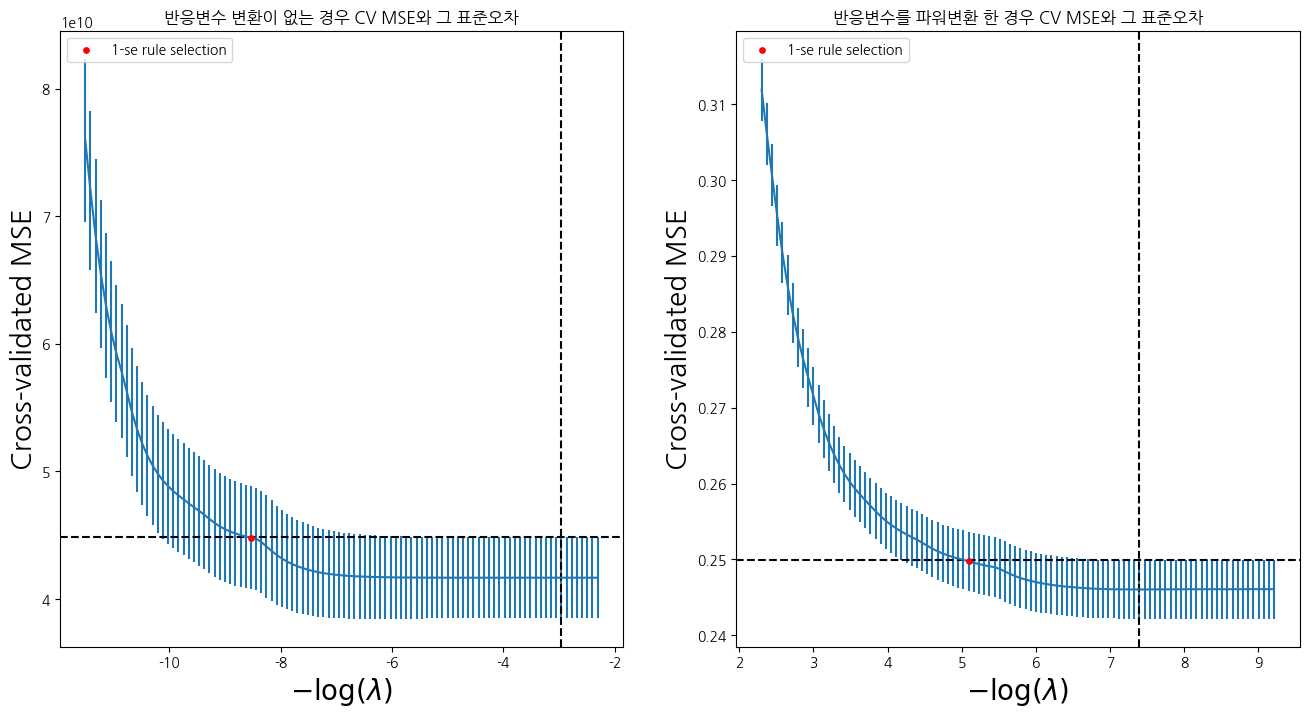

선택된 lambda(raw) =  19.17910,  5094.13801
선택된 lambda(powertransform) =  0.00061,  0.00614


In [55]:
## plotting
LassoCV_fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].errorbar(-np.log(LassoCV.alphas_), LassoCV.mse_path_.mean(1),
            yerr=LassoCV.mse_path_.std(1) / np.sqrt(10))
axs[0].axvline(-np.log(LassoCV.alpha_), c='k', ls='--')
axs[0].axhline(min_mse + min_std / np.sqrt(10), c = 'k', ls = '--')
axs[0].set_xlabel('$-\log(\lambda)$', fontsize=20)
axs[0].set_ylabel('Cross-validated MSE', fontsize=20)
axs[0].scatter(-np.log(LassoCV.alphas_[simple_indx]), mse_list[simple_indx],
           color = "red", s = 15, label = "1-se rule selection", zorder = 5)
axs[0].set_title("반응변수 변환이 없는 경우 CV MSE와 그 표준오차")
axs[0].legend()

axs[1].errorbar(-np.log(LassoCV_trans.alphas_), LassoCV_trans.mse_path_.mean(1),
            yerr=LassoCV_trans.mse_path_.std(1) / np.sqrt(10))
axs[1].axvline(-np.log(LassoCV_trans.alpha_), c='k', ls='--')
axs[1].axhline(min_mse_trans + min_std_trans / np.sqrt(10), c = 'k', ls = '--')
axs[1].set_xlabel('$-\log(\lambda)$', fontsize=20)
axs[1].set_ylabel('Cross-validated MSE', fontsize=20)
axs[1].scatter(-np.log(LassoCV_trans.alphas_[simple_indx_trans]), mse_list_trans[simple_indx_trans],
           color = "red", s = 15, label = "1-se rule selection", zorder = 5)
axs[1].set_title("반응변수를 파워변환 한 경우 CV MSE와 그 표준오차")
axs[1].legend()

plt.show()

## showing parameter
print(f'선택된 lambda(raw) = {LassoCV.alpha_ : .5f}, {LassoCV.alphas_[simple_indx] : .5f}')
print(f"선택된 lambda(powertransform) = {LassoCV_trans.alpha_ : .5f}, {LassoCV_trans.alphas_[simple_indx_trans] : .5f}")

In [18]:
np.exp(8)

2980.9579870417283

In [56]:
with open("scoring_dict.pkl", "wb") as f :
    pickle.dump(scoring_dict, f)

In [33]:
scoring_dict

{'Linear Regression with days': 196509.2480378606,
 'Linear Regression with month': 196439.31546500308,
 'Ridge Regression': 196381.86090422017,
 'Ridge Regression with transformed price': 221208.76803379238,
 'Ridge Regression with 1-se rule': 200062.39715456305,
 'Ridge Regression with transformed price & 1-se rule': 240907.14965825903,
 'GAM': 156864.5731076838,
 'GAM with 1-se rule': 165829.69703731456,
 'XGBoost CV': 107541.7772014463,
 'Tree CV': 172828.85210206837,
 'Linear Regression with Reduction': 192870.63556905373,
 'PCR with 26th PC': 192850.14039133323,
 'Lasso Regression': 196381.78750713536,
 'Lasso Regression with transformed price': 221208.62262207255,
 'Lasso Regression with 1-se rule': 200062.39715456305,
 'Lasso Regression with transformed price & 1-se rule': 241576.01843636567}

In [27]:
import pandas as pd
import numpy as np
import pickle

import plotly.express as px
import plotly.graph_objects as go

In [2]:
with open("scoring_dict.pkl", "rb") as f :
    scoring_dict = pickle.load(f)

In [24]:
linear_dict = {k:float(v) for k, v in scoring_dict.items() if (("Linear" in k) or ("Ridge" in k) or ("Lasso" in k)) and ("Reduction" not in k)}

In [93]:
df_score = pd.DataFrame({"method" : linear_dict.keys(), "score" : linear_dict.values()}).iloc[[1,0,2,4,3,5,6,8,7,9]]

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = df_score.score,
        y = df_score.method,
        text = df_score.score,
        orientation = "h",
        texttemplate = "%{text:.4f}",
        marker_line=dict(width=5, color='black')
    )
)

fig.update_layout(height = 800, title = dict(text="선형 모형 적합결과의 비교(RMSE)", font=dict(size=30), x = 0.5, y = 0.95))
fig["data"][0]["marker"]["color"] = ["skyblue"]*2 + ["green"]*4 + ["blue"]*4
fig["data"][0]["marker"]["line"]["color"] = ["red", "skyblue"] + ["red"] + ["green"]*3 + ["red"] + ["blue"]*3

fig.show()